In [1]:
import numpy as np
from pylab import *
from craco.cardcap import CardcapFile
from astropy.io import fits

%matplotlib notebook

In [2]:
!ls data/SB40884/short

0407-debughdr-lsb11-dp-b0.fits	0407-debughdr-lsb11-dp-ball.fits
0407-debughdr-lsb11-dp-b0.npy	0407-debughdr-lsb11-dp-ball.npy


In [3]:
fname = 'data/SB40884/short/0407-debughdr-lsb11-dp-b0.fits'
#fname = 'data/SB40891/short/vela-debughdr-lsb11-dp-b0.fits'

In [4]:
# if you want to look at frequencies, you need to load teh fits directly.
ccap = CardcapFile(fname)
ccap.dtype


dtype([('frame_id', '<u8'), ('bat', '<u8'), ('beam_number', 'u1'), ('sample_number', 'u1'), ('channel_number', 'u1'), ('fpga_id', 'u1'), ('nprod', '<u2'), ('flags', 'u1'), ('zero1', 'u1'), ('version', '<u4'), ('zero3', '<u4'), ('data', '<i2', (1, 465, 2, 2))])

In [5]:
ccap.frequencies


array([[1099.57407407, 1100.57407407, 1101.57407407, 1102.57407407],
       [1099.74074074, 1100.74074074, 1101.74074074, 1102.74074074],
       [1099.90740741, 1100.90740741, 1101.90740741, 1102.90740741],
       [1100.07407407, 1101.07407407, 1102.07407407, 1103.07407407],
       [1100.24074074, 1101.24074074, 1102.24074074, 1103.24074074],
       [1100.40740741, 1101.40740741, 1102.40740741, 1103.40740741]])

In [6]:
ccap.frequencies.shape

(6, 4)

In [7]:
flatfreq = ccap.frequencies.T.flatten()
fdiff = flatfreq[1:] - flatfreq[:-1]
# check frequency offset is always 166 kHz
fdiff

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667])

<IPython.core.display.Javascript object>


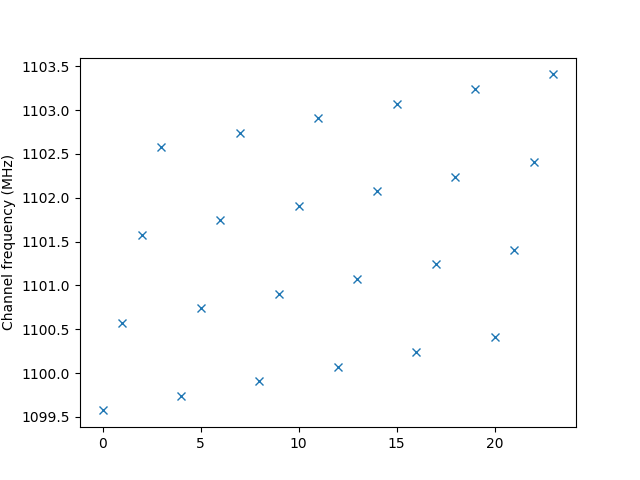

Text(0, 0.5, 'Channel frequency (MHz)')

In [8]:
figure()
plot(ccap.frequencies.flat,'x') 
# the key point here is that to order things by channel, you need to read FPGA first, then channel
ylabel('Channel frequency (MHz)')

In [9]:
# if you have CardcaptureFile you can do this
pkts = ccap.load_packets()
pkts.shape

# otherwise
pkts = np.load(fname.replace('.fits','.npy'))

<IPython.core.display.Javascript object>


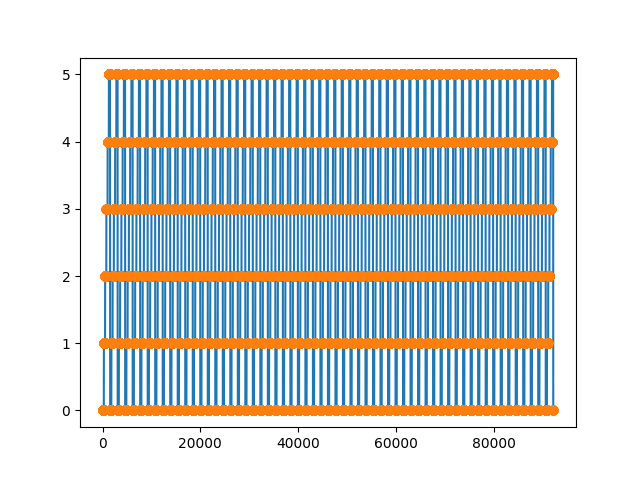

In [10]:
figure()
plot(pkts['fpga_id'])
plot(pkts['fpga_id'],'o')

<IPython.core.display.Javascript object>


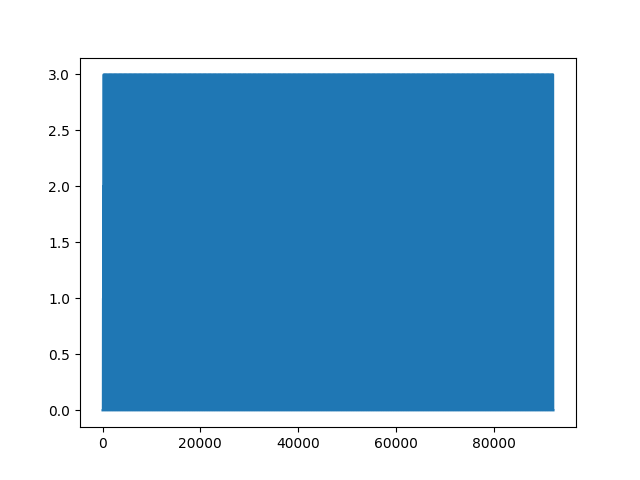

In [11]:
figure()
plot(pkts['channel_number'])

<IPython.core.display.Javascript object>


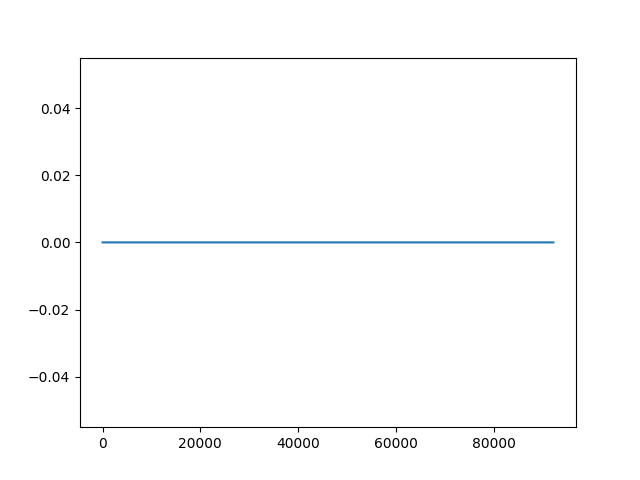

In [12]:
figure()
plot(pkts['beam_number'])
assert np.all(pkts['beam_number'] == 0)

In [13]:
pkts.shape

(92223,)

In [14]:
nsamp_per_block = 2048//32
nchan = 4
nfpga = 6
nbl = 465
npol = 2
blksize = nsamp_per_block*nchan*nfpga
blksize

1536

In [15]:
nblk = len(pkts)//blksize
nblk

60

In [16]:
pkts = pkts[:nblk*blksize] # truncate data to an integer number of blocks

In [17]:
pkts['data'].shape

(92160, 1, 465, 2, 2)

In [18]:
d = pkts['data'].reshape(-1, nfpga, nchan, nsamp_per_block, nbl, npol, 2) # set shape 
d.shape

(60, 6, 4, 64, 465, 2, 2)

In [19]:
# because of weirdness in the correlator each FPGA processes 4 channels, but to sort the 
# channels in order you need to do
# fpga0 channel 0, fpga 1 channel 0, fpga 2 channel 0 fpga 3 channel 0, fpga0 channel 1, ... etc.
# so with this transpose we put the time axes out the left, then re-order the channel axes, and leave everythign else
# alone

d = np.transpose(d, (0,3,2,1,4,5,6))
d.shape

(60, 64, 4, 6, 465, 2, 2)

In [20]:
# now we compress the time and channel axes
d = d.reshape(d.shape[0]*d.shape[1], d.shape[2]*d.shape[3], d.shape[4], d.shape[5], d.shape[6])

In [21]:
d.shape

(3840, 24, 465, 2, 2)

In [22]:
# make a complex array - this doubles the memory required, but who cares
dc = np.zeros(d.shape[:-1], dtype=np.complex64)
dc.real = d[..., 0]
dc.imag = d[..., 1]
dc.shape

(3840, 24, 465, 2)

In [305]:
dcmean = dc.mean(axis=0)
dcmean.shape

(24, 465, 2)

In [23]:
pol1 = dc[...,0]
pol2 = dc[...,1]

<IPython.core.display.Javascript object>


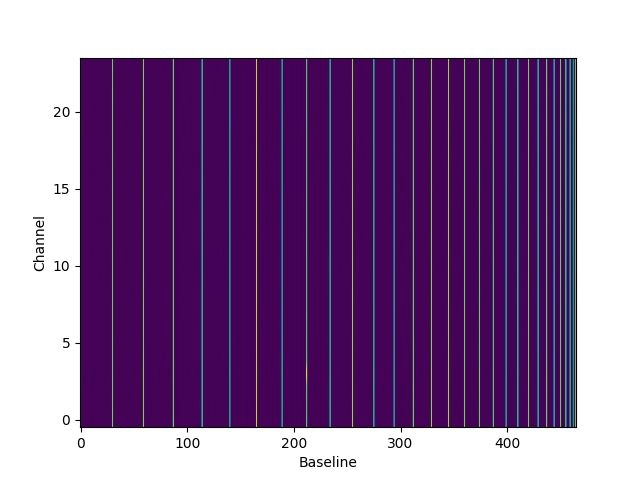

Text(0, 0.5, 'Channel')

In [24]:
figure()
imshow(abs(pol1.mean(axis=0)), aspect='auto', origin='lower')
xlabel('Baseline')
ylabel('Channel')

In [457]:
nant = 30
idx = 0
products = []
revproducts = {}
auto_products = []
cross_products = []
for a1 in range(1, nant+1):
    for a2 in range(a1, nant+1):
        print(f'{a1}-{a2}:{idx}')
        products.append((a1,a2))
        revproducts[(a1,a2)] = idx
        if a1 == a2:
            auto_products.append(idx)
        else:
            cross_products.append(idx)
            
        idx += 1
      
        
products = np.array(products, dtype=[('a1',np.int16), ('a2', np.int16)])

1-1:0
1-2:1
1-3:2
1-4:3
1-5:4
1-6:5
1-7:6
1-8:7
1-9:8
1-10:9
1-11:10
1-12:11
1-13:12
1-14:13
1-15:14
1-16:15
1-17:16
1-18:17
1-19:18
1-20:19
1-21:20
1-22:21
1-23:22
1-24:23
1-25:24
1-26:25
1-27:26
1-28:27
1-29:28
1-30:29
2-2:30
2-3:31
2-4:32
2-5:33
2-6:34
2-7:35
2-8:36
2-9:37
2-10:38
2-11:39
2-12:40
2-13:41
2-14:42
2-15:43
2-16:44
2-17:45
2-18:46
2-19:47
2-20:48
2-21:49
2-22:50
2-23:51
2-24:52
2-25:53
2-26:54
2-27:55
2-28:56
2-29:57
2-30:58
3-3:59
3-4:60
3-5:61
3-6:62
3-7:63
3-8:64
3-9:65
3-10:66
3-11:67
3-12:68
3-13:69
3-14:70
3-15:71
3-16:72
3-17:73
3-18:74
3-19:75
3-20:76
3-21:77
3-22:78
3-23:79
3-24:80
3-25:81
3-26:82
3-27:83
3-28:84
3-29:85
3-30:86
4-4:87
4-5:88
4-6:89
4-7:90
4-8:91
4-9:92
4-10:93
4-11:94
4-12:95
4-13:96
4-14:97
4-15:98
4-16:99
4-17:100
4-18:101
4-19:102
4-20:103
4-21:104
4-22:105
4-23:106
4-24:107
4-25:108
4-26:109
4-27:110
4-28:111
4-29:112
4-30:113
5-5:114
5-6:115
5-7:116
5-8:117
5-9:118
5-10:119
5-11:120
5-12:121
5-13:122
5-14:123
5-15:124
5-16:125
5-17:126
5-

In [459]:
# we think we have a 9x9 transpose problem - need to work out how to undo this.
npol = 2
nblk = 36*2 // 9
revproducts_t = {}
nant_total = 36
for a1 in range(nant_total):
    for a2 in range(nant_total):
        for p1 in range(npol):
            for p2 in range(npol):
                idx1 = p1 + npol*a1
                idx2 = p2 + npol*a2
                blk1 = idx1 // 9
                blk2 = idx2 // 9
                
                
                
                    
                

<IPython.core.display.Javascript object>


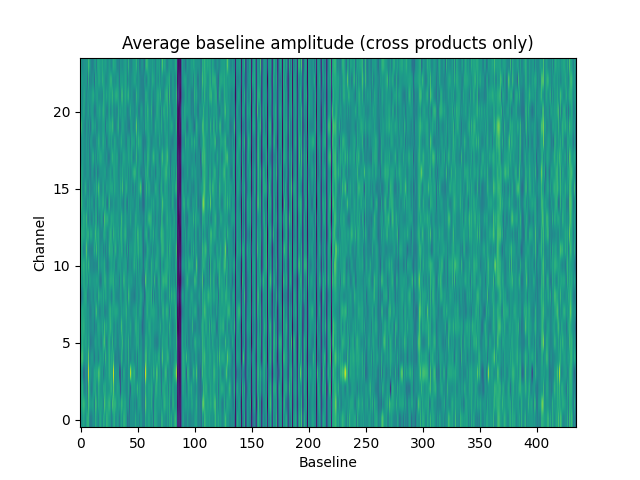

Text(0.5, 1.0, 'Average baseline amplitude (cross products only)')

In [26]:
figure()
imshow(abs(pol1.mean(axis=0)[0:, cross_products]), aspect='auto', origin='lower')
xlabel('Baseline')
ylabel('Channel')
title('Average baseline amplitude (cross products only)')

<IPython.core.display.Javascript object>


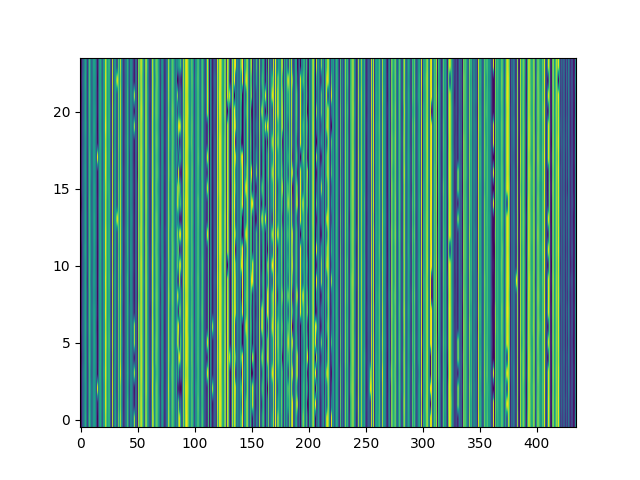

In [27]:
figure()
imshow(np.angle(pol1.mean(axis=0)[:, cross_products]), aspect='auto', origin='lower')

<IPython.core.display.Javascript object>


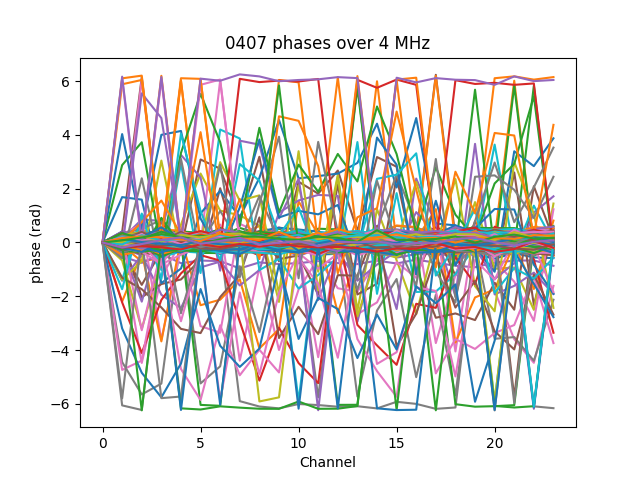

Text(0.5, 1.0, '0407 phases over 4 MHz')

In [28]:
figure()
ang = np.angle(pol1.mean(axis=0)[:, cross_products])
plot(ang - ang[0, :]) # normalise to first channel so we can see a bit better what's going on
xlabel('Channel')
ylabel('phase (rad)')
title('0407 phases over 4 MHz')

In [29]:
dc.shape

(3840, 24, 465, 2)

<IPython.core.display.Javascript object>


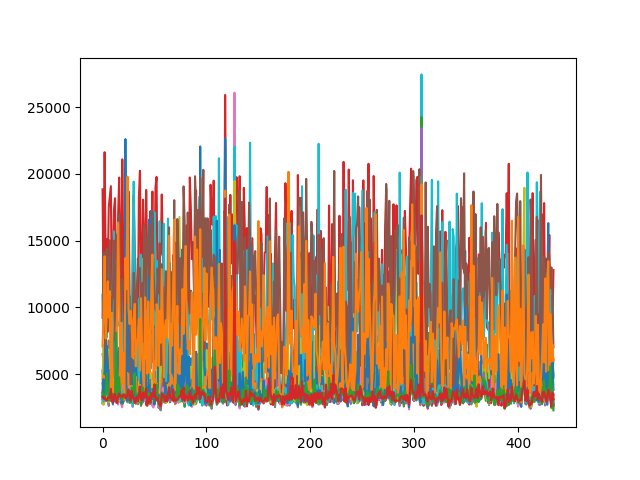

In [30]:
figure()
_ = plot(dc[:,:,cross_products,0].imag.max(axis=0).T)

In [31]:
dc.shape

(3840, 24, 465, 2)

In [32]:
dcp = dc.reshape(-1, 24, 465*2)

In [33]:
dcp.shape

(3840, 24, 930)

<IPython.core.display.Javascript object>


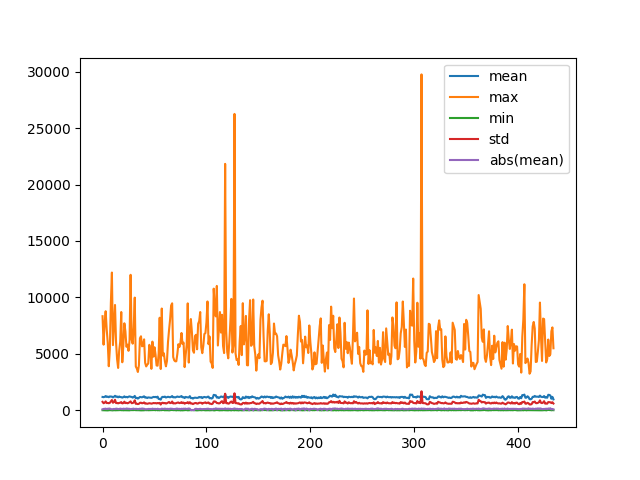

In [34]:
figure()
amp = abs(dc[:,0,cross_products,0])
plot(amp.mean(axis=0), label='mean')
plot(amp.max(axis=0), label='max')
plot(amp.min(axis=0), label='min')
plot(amp.std(axis=0), label='std')
plot(abs(dc[:,0,cross_products,0].mean(axis=0)), label='abs(mean)')
legend()


<IPython.core.display.Javascript object>


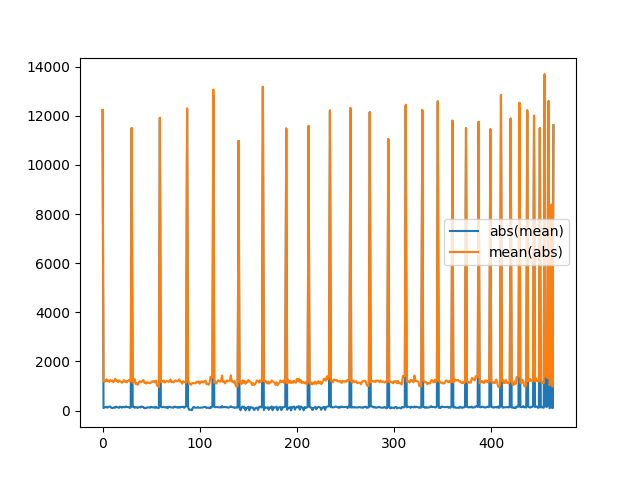

In [35]:

figure()
absmean = abs(pol1.mean(axis=0)[0, :])
plot(absmean, label='abs(mean)')
plot(abs(pol1).mean(axis=0)[0, :], label='mean(abs)')
legend()

In [36]:
badidxs = np.where(absmean < 74)[0]
badbls = products[badidxs]
print(badbls)

[(4,  6) (4,  7) (4,  8) (4,  9) (6,  8) (6, 13) (6, 17) (6, 22) (6, 26)
 (7,  8) (7, 13) (7, 17) (7, 22) (7, 26) (8,  9) (8, 13) (8, 17) (8, 22)
 (8, 26) (9, 13) (9, 17) (9, 22) (9, 26)]


<IPython.core.display.Javascript object>


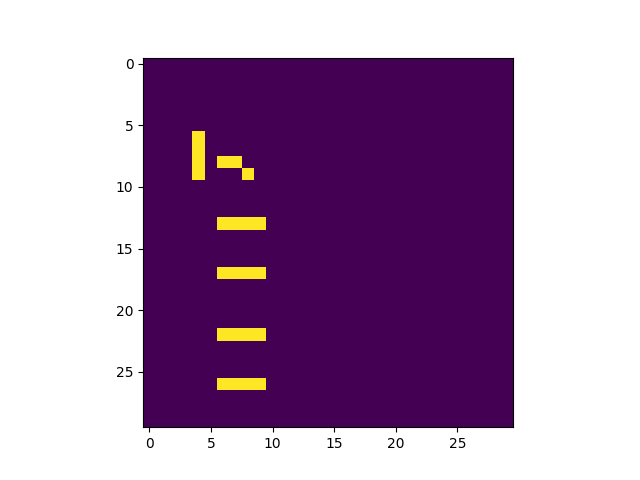

In [37]:
corrdata = np.zeros((30,30))
for a1, a2 in badbls:
    corrdata[a2,a1] = 1
    
figure()
imshow(corrdata)

In [38]:
pol1.shape

(3840, 24, 465)

<IPython.core.display.Javascript object>


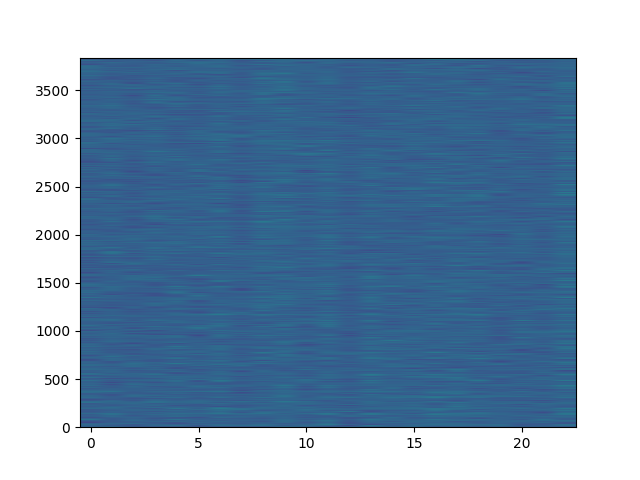

In [39]:
figure()
imshow(np.sqrt(abs(pol1[:,0,badidxs])), aspect='auto', origin='lower')

<IPython.core.display.Javascript object>


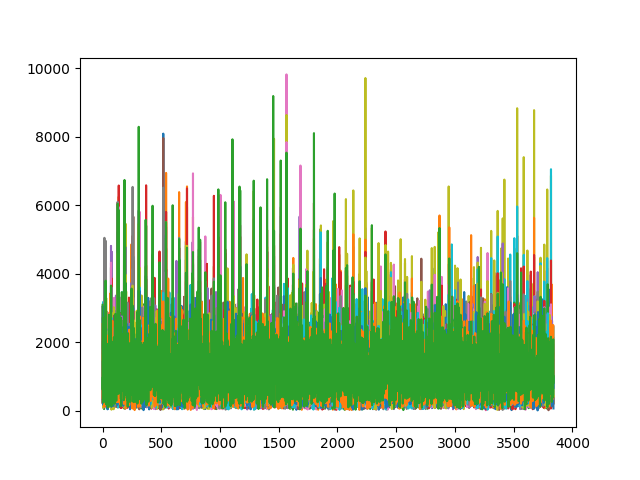

In [40]:
figure()
plot(abs(pol1[:,0,badidxs]))

<IPython.core.display.Javascript object>


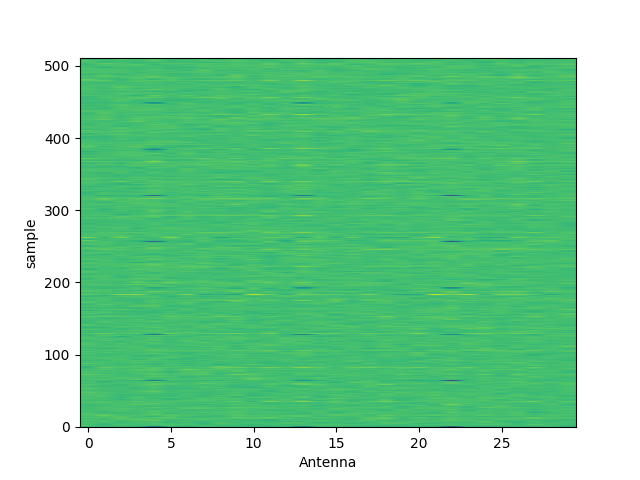

Text(0, 0.5, 'sample')

In [41]:
figure()
auto = abs(pol1[:,:9,auto_products].mean(axis=1))
imshow(auto[:512,:] - auto.mean(axis=0), aspect='auto', origin='lower')
xlabel('Antenna')
ylabel('sample')

<IPython.core.display.Javascript object>


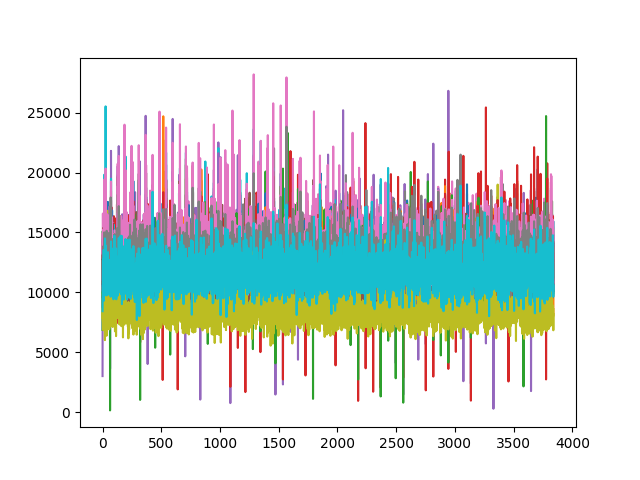

In [42]:
figure()
_ = plot(abs(pol1[:,0,auto_products]))

<IPython.core.display.Javascript object>


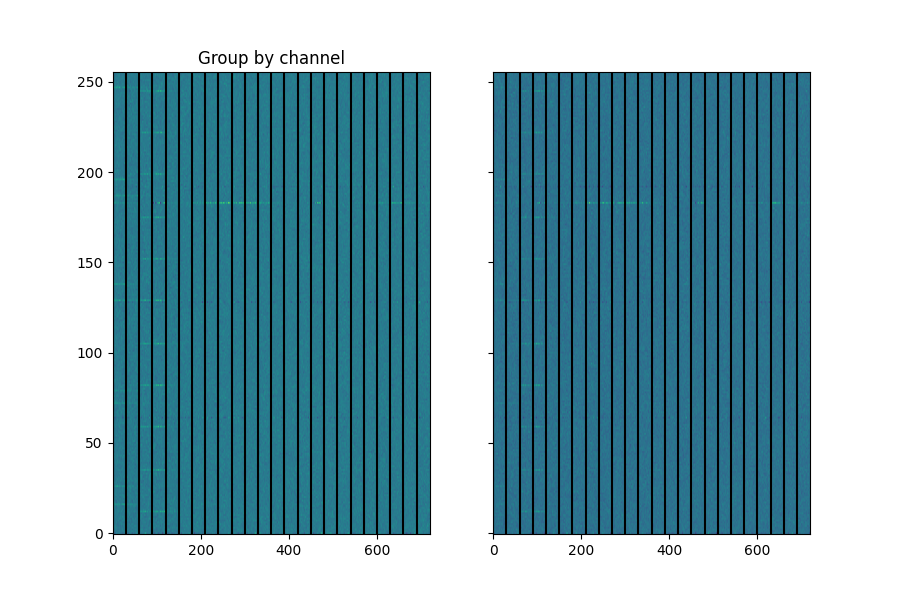

In [43]:
fig, ax = subplots(1,2, sharex=True, sharey=True)
fig.set_size_inches(9,6)

auto = abs(pol1[:256,:,auto_products]).reshape(-1,24*len(auto_products))
auto2 = abs(pol2[:256,:,auto_products]).reshape(-1,24*len(auto_products))
ax[0].imshow(auto - auto.mean(axis=0), aspect='auto', origin='lower')
ax[1].imshow(auto2 - auto2.mean(axis=0), aspect='auto', origin='lower')
ax[0].set_title('Group by channel')

for p in range(24):
    ax[0].axvline(p*len(auto_products), c='k')
    ax[1].axvline(p*len(auto_products), c='k')

<IPython.core.display.Javascript object>


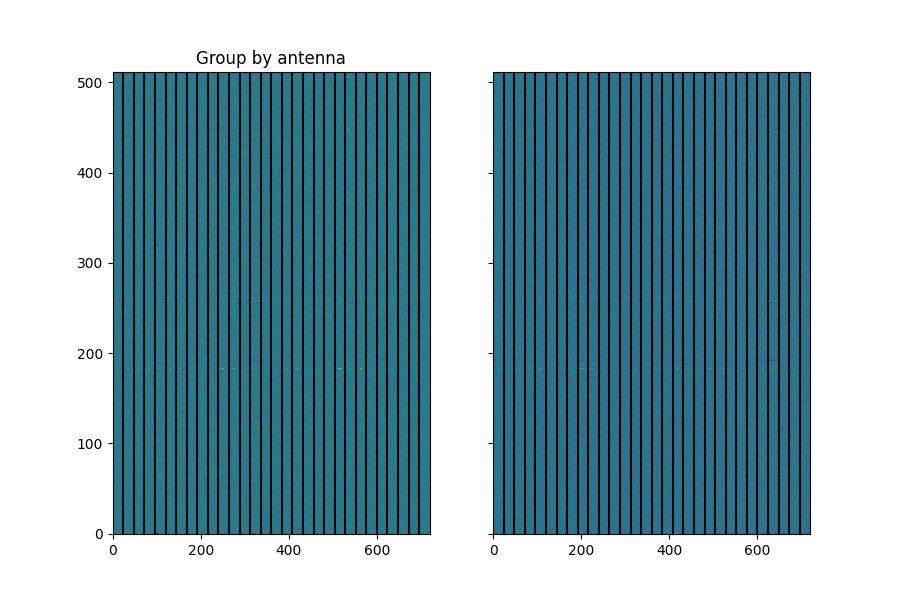

<IPython.core.display.Javascript object>


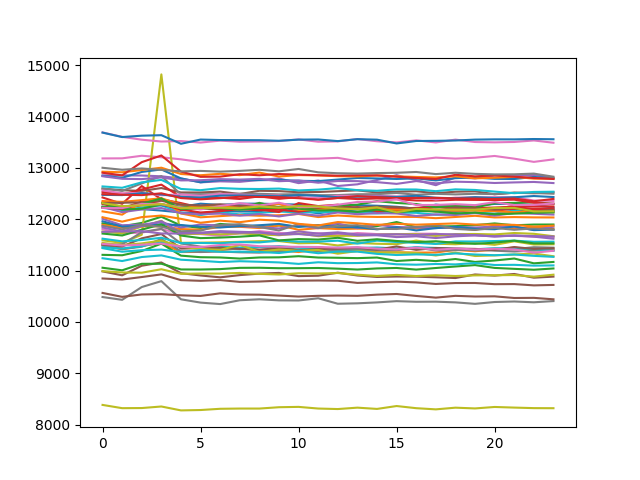

In [44]:
fig, ax = subplots(1,2, sharex=True, sharey=True)
fig.set_size_inches(9,6)
blslice=auto_products

auto = abs(pol1[:512,:,auto_products]).transpose(0,2,1).reshape(-1,24*len(auto_products))
auto2 = abs(pol2[:512,:,auto_products]).transpose(0,2,1).reshape(-1,24*len(auto_products))
ax[0].imshow(auto - auto.mean(axis=0), aspect='auto', origin='lower')
ax[1].imshow(auto2 - auto2.mean(axis=0), aspect='auto', origin='lower')
ax[0].set_title('Group by antenna')
for p in range(len(auto_products)):
    ax[0].axvline(p*24, c='k')
    ax[1].axvline(p*24, c='k')
    
figure()
plot(abs(pol1[:,:,blslice].mean(axis=0)))
_ = plot(abs(pol2[:,:,blslice].mean(axis=0)))

<IPython.core.display.Javascript object>


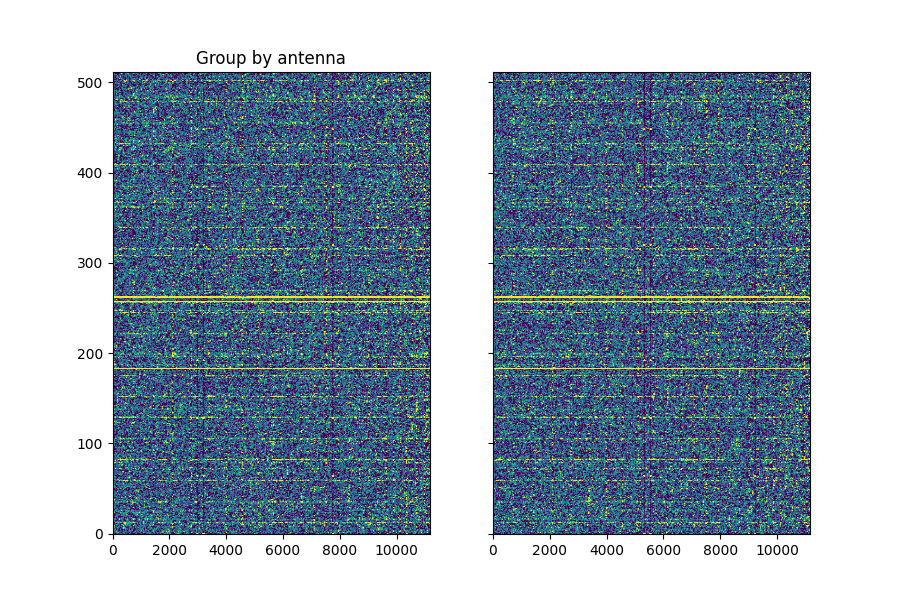

/data/craco/ban115/craco-python/venv/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


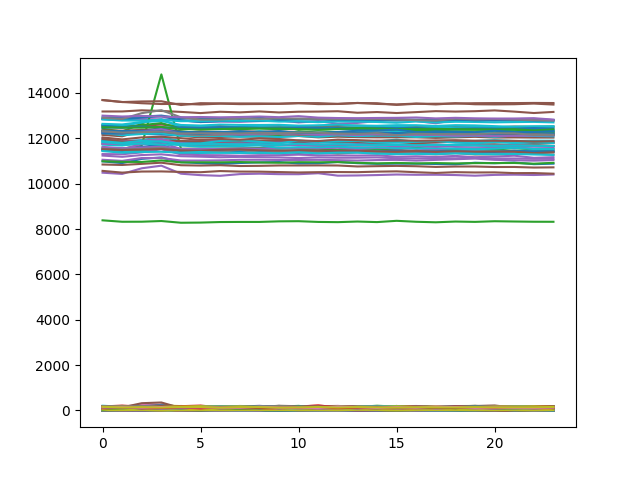

In [45]:
fig, ax = subplots(1,2, sharex=True, sharey=True)
fig.set_size_inches(9,6)
vmin = -100
vmax = 200
nt = 512
#blslice = cross_products
blslice = slice(None)
#blslice = badidxs

auto = abs(pol1[:nt,:,blslice]).transpose(0,2,1).reshape(nt,-1)
auto2 = abs(pol2[:nt,:,blslice]).transpose(0,2,1).reshape(nt,-1)
ax[0].imshow(auto - auto.mean(axis=0), aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
ax[1].imshow(auto2 - auto2.mean(axis=0), aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
ax[0].set_title('Group by antenna')
#for p in range(len(cross_products)):
#    ax[0].axvline(p*24, c='k')
#    ax[1].axvline(p*24, c='k')

figure()
plot(abs(pol1[:,:,blslice].mean(axis=0)))
_ = plot(abs(pol2[:,:,blslice].mean(axis=0)))


<IPython.core.display.Javascript object>


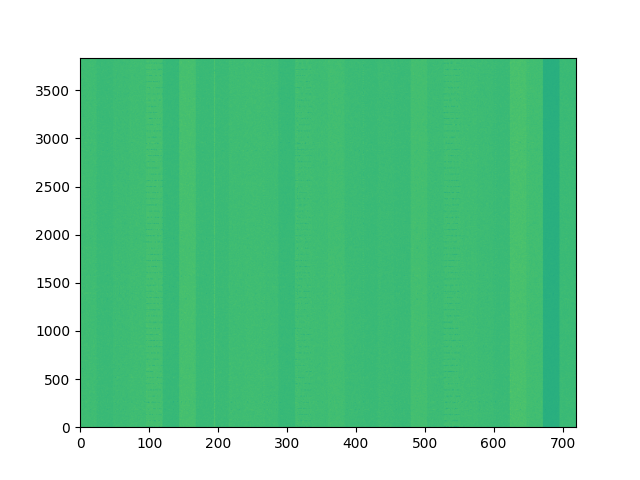

In [46]:
figure()
imshow(pol1[:, :, auto_products].real.transpose(0,2,1).reshape(-1, 24*len(auto_products)), aspect='auto', origin='lower')

<IPython.core.display.Javascript object>


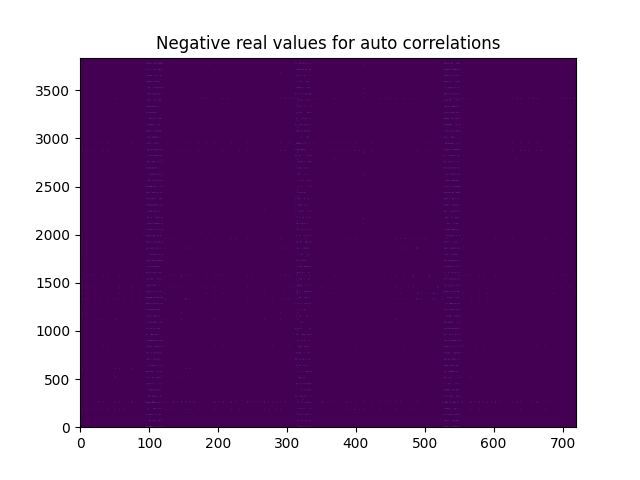

/data/craco/ban115/craco-python/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Got 2609 autocorrelations < 0
  import sys


In [47]:
figure()
negreal = pol1[:, :, auto_products].real.transpose(0,2,1).reshape(-1, 24*len(auto_products))<0
imshow(negreal, aspect='auto', origin='lower')
title('Negative real values for auto correlations')
import warnings
if negreal.sum() > 0:
    warnings.warn(f'Got {negreal.sum()} autocorrelations < 0')

<IPython.core.display.Javascript object>


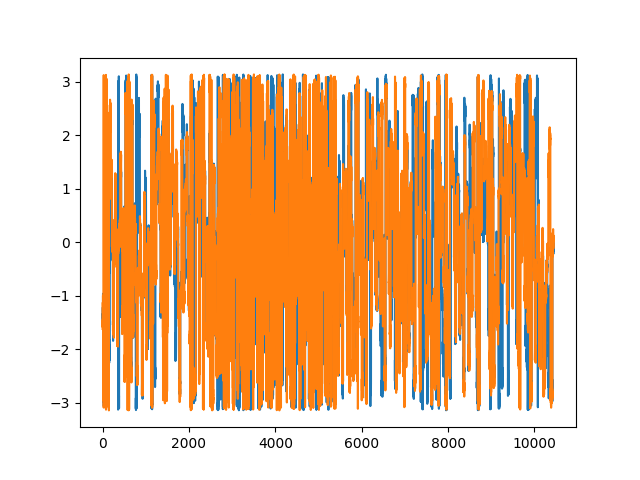

In [48]:
figure()
pol1angle = np.angle(pol1[:, :, cross_products].mean(axis=0)).T.flatten()
pol2angle = np.angle(pol2[:, :, cross_products].mean(axis=0)).T.flatten()                                                                                                                                                
plot(pol1angle)
plot(pol2angle)

<IPython.core.display.Javascript object>


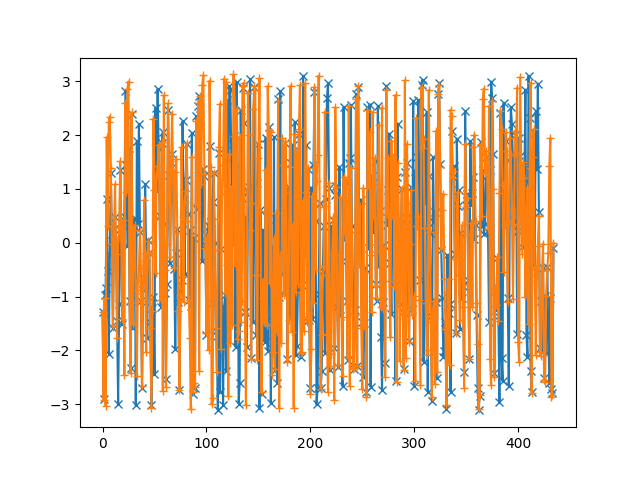

In [49]:
pol1angleavg = np.angle(pol1[:, :, cross_products].mean(axis=0).mean(axis=0))
pol2angleavg = np.angle(pol2[:, :, cross_products].mean(axis=0).mean(axis=0))
figure()
plot(pol1angleavg,'-x')
plot(pol2angleavg,'-+')

<IPython.core.display.Javascript object>


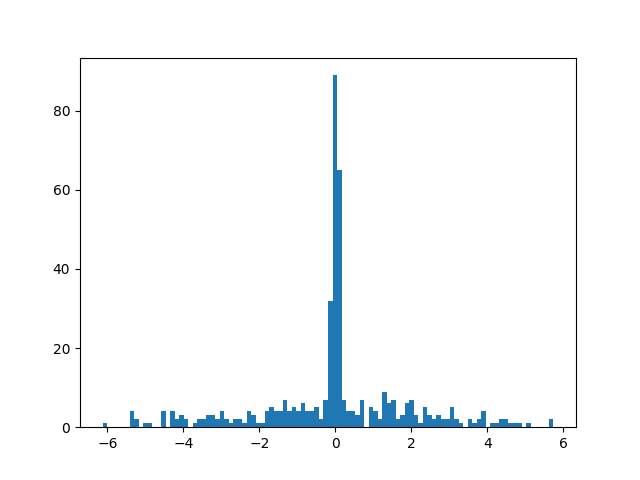

In [50]:
figure()
_ = hist(pol1angleavg-pol2angleavg, bins=100)

<IPython.core.display.Javascript object>


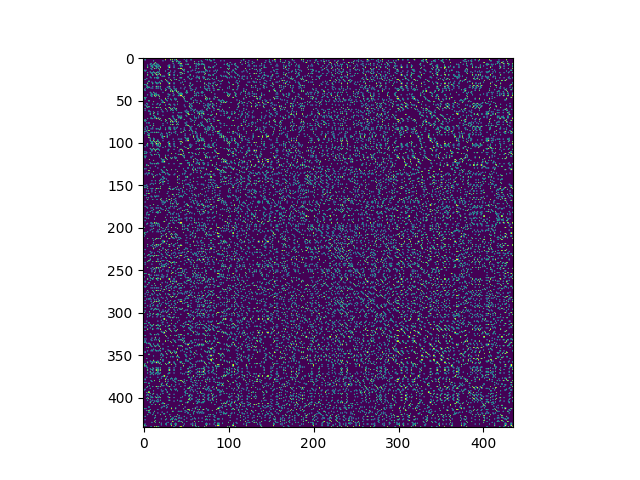

In [51]:
n = len(pol1angleavg)
d = np.zeros((n,n))
for ibl in range(n):
    d[ibl,:] = pol1angleavg[ibl] - pol2angleavg
figure()
imshow(abs(d) < 0.1*np.pi)

<IPython.core.display.Javascript object>


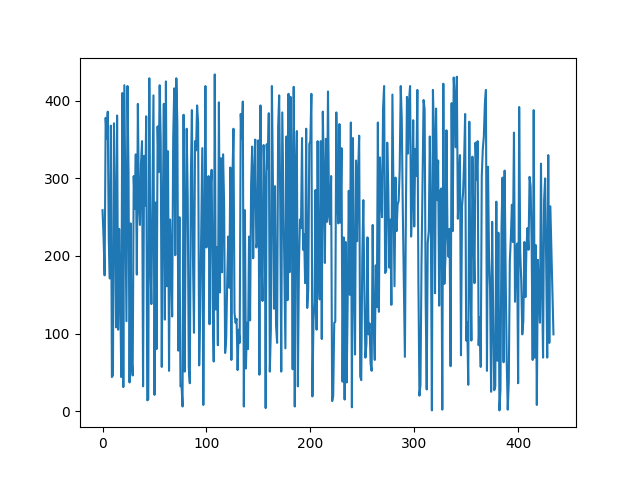

In [52]:
n = len(pol1angleavg)
d = np.zeros(n)
for ibl in range(n):
    d[ibl] = np.argmin(abs(pol1angleavg[ibl] - pol2angleavg))
figure()
plot(d)

<IPython.core.display.Javascript object>


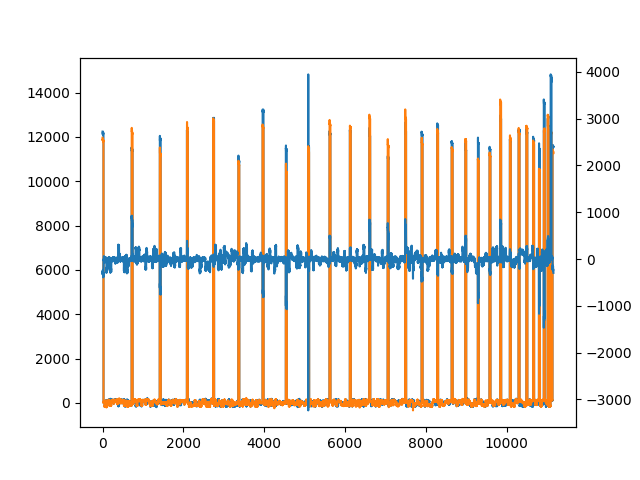

In [53]:
figure()
pol1real = (pol1[:, :, :].mean(axis=0)).real.T.flatten()
pol2real = (pol2[:, :, :].mean(axis=0)).real.T.flatten()                                                                                                                                                
plot(pol1real)
plot(pol2real)
twinx()
plot(pol2real - pol1real)

In [54]:
pol1avg = pol1.mean(axis=0).mean(axis=0)
pol2avg = pol2.mean(axis=0).mean(axis=0)


def triplot(pol1angle, pol2angle, funcname, threshold, **kwargs):
    pol1tri = np.zeros((nant,nant))
    pol2tri = np.zeros((nant,nant))

    for a1 in range(nant):
        for a2 in range(a1, nant):
            key = (a1+1, a2+1)
            pol1tri[a2,a1] = pol1angle[revproducts[key]]
            pol2tri[a2,a1] = pol2angle[revproducts[key]]

    fig,ax = subplots(1,4, sharex=True, sharey=True)
    ax[0].imshow(pol1tri, aspect='auto', **kwargs)
    ax[1].imshow(pol2tri, aspect='auto', **kwargs)
    ax[2].imshow(pol2tri - pol1tri, aspect='auto', **kwargs)
    ax[3].imshow(abs(pol2tri - pol1tri)<threshold, aspect='auto')

    fig.set_size_inches(9,9/4)
    ax[0].set_title(f'{funcname}(pol1)')
    ax[1].set_title(f'{funcname}(pol2)')
    ax[2].set_title(f'{funcname}(pol2) - {funcname}(pol1)')
    ax[3].set_title(f'diff < {threshold:0.1f}')




<IPython.core.display.Javascript object>


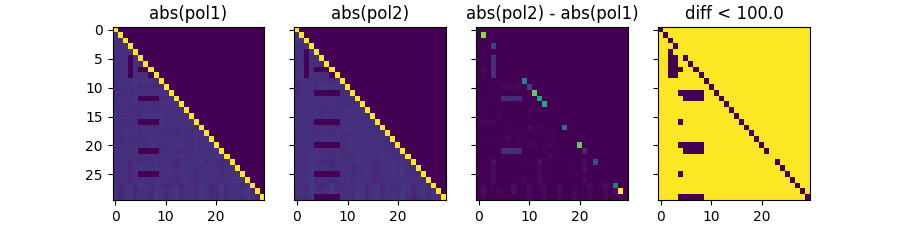

In [55]:
triplot(np.abs(pol1avg), np.abs(pol2avg),'abs', 100,vmin=0,vmax=1000)


<IPython.core.display.Javascript object>


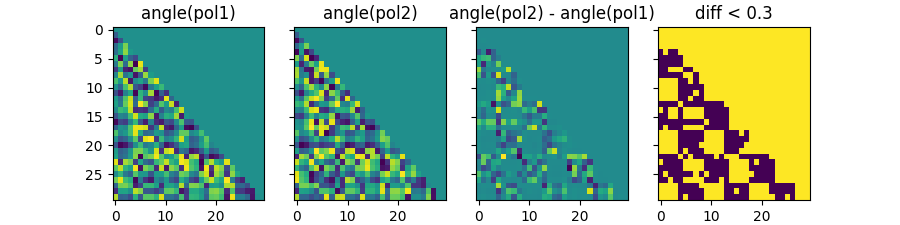

In [56]:
triplot(np.angle(pol1avg), np.angle(pol2avg),'angle', np.pi*0.1,)


<IPython.core.display.Javascript object>


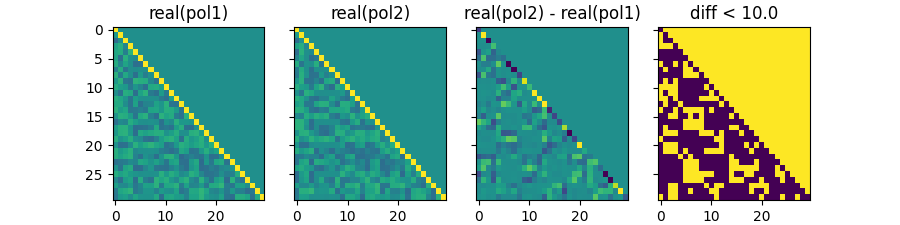

In [57]:
triplot(pol1avg.real, pol2avg.real, 'real',10, vmin=-500,vmax=500)


<IPython.core.display.Javascript object>


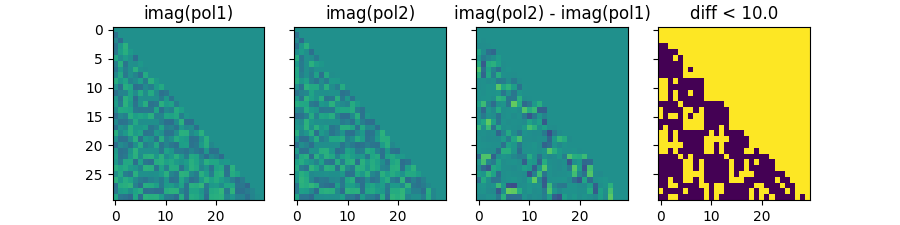

In [58]:
triplot(pol1avg.imag, pol2avg.imag, 'imag',10, vmin=-500,vmax=500)


In [118]:
from casatools import ms

In [120]:
import casatools
import casatools.quanta as qa

In [60]:
import glob
for msname in glob.glob('data/SB40884/*.ms'):
    myms = ms()
    myms.open(msname)
    print(msname)
    print(myms.summary())
    myms.close()


data/SB40884/2022-05-16_061726_0.ms
{'BeginTime': 59715.261880751095, 'EndTime': 59715.269023151086, 'IntegrationTime': 617.1033592224121, 'field_0': {'code': '', 'direction': {'m0': {'unit': 'rad', 'value': 2.2485658529860277}, 'm1': {'unit': 'rad', 'value': -0.8014347755689529}, 'refer': 'J2000', 'type': 'direction'}, 'name': 'CRAFTCal_beam0_J083*-4510_beam0'}, 'nfields': 1, 'numrecords': 41292, 'scan_0': {'0': {'BeginTime': 59715.261880751095, 'EndTime': 59715.269023151086, 'FieldId': 0, 'FieldName': 'CRAFTCal_beam0_J0835-4510_beam0', 'IntegrationTime': 9.953279999999996, 'SpwIds': array([0]), 'StateId': -1, 'nRow': 41292, 'scanId': 0}}, 'timeref': 'UTC'}
data/SB40884/2022-05-16_062953_0.ms
{'BeginTime': 59715.2705207511, 'EndTime': 59715.27766315109, 'IntegrationTime': 617.1033592224121, 'field_0': {'code': '', 'direction': {'m0': {'unit': 'rad', 'value': 1.08358766610068}, 'm1': {'unit': 'rad', 'value': -1.1605561465277119}, 'refer': 'J2000', 'type': 'direction'}, 'name': 'CRAFTCa

In [79]:
myms.open('data/SB40884/2022-05-23_061642_0.ms')

True

In [106]:
summary = myms.summary()
summary

{'BeginTime': 59722.2613649111,
 'EndTime': 59722.26827691109,
 'IntegrationTime': 597.1967992782593,
 'field_0': {'code': '',
  'direction': {'m0': {'unit': 'rad', 'value': 1.08358766610068},
   'm1': {'unit': 'rad', 'value': -1.1605561465277119},
   'refer': 'J2000',
   'type': 'direction'},
  'name': 'CRAFTCal_beam0_0407*658_beam0'},
 'nfields': 1,
 'numrecords': 39960,
 'scan_0': {'0': {'BeginTime': 59722.2613649111,
   'EndTime': 59722.26827691109,
   'FieldId': 0,
   'FieldName': 'CRAFTCal_beam0_0407-658_beam0',
   'IntegrationTime': 9.953279999999987,
   'SpwIds': array([0]),
   'StateId': -1,
   'nRow': 39960,
   'scanId': 0}},
 'timeref': 'UTC'}

In [81]:
myms.getscansummary()

{'0': {'0': {'BeginTime': 59722.261422511096,
   'DDIds': array([0]),
   'EndTime': 59722.268219311096,
   'FieldId': 0,
   'IntegrationTime': 9.95327999999993,
   'SpwIds': array([0]),
   'StateId': -1,
   'nRow': 39960}}}

In [82]:
myms.getspectralwindowinfo()

{'0': {'Chan1Freq': 859990740.7407407,
  'ChanWidth': 999999.9999999827,
  'Frame': 'TOPO',
  'NumChan': 288,
  'NumCorr': 4,
  'PolId': 0,
  'RefFreq': 859990740.7407407,
  'SpectralWindowId': 0,
  'TotalWidth': 287999999.999995}}

In [90]:
#myms.lister(timerange='06:20:00') # spends a long time printing, but ust picks out a single integration 

True

In [84]:
print('Freq range:', ccap.frequencies.min(), ccap.frequencies.max())

Freq range: 1099.574074074074 1103.4074074074088


In [88]:
specinfo = myms.getspectralwindowinfo()['0']
mschannels = np.arange(specinfo['NumChan'])*specinfo['ChanWidth'] + specinfo['Chan1Freq']


In [89]:
chan = np.argmin(abs(mschannels/1e6 - ccap.frequencies.min()))
chan

240

In [430]:
ants = list(np.arange(1,10))
ants_string = ','.join(map(str, ants))
ants

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [431]:
#myms.lister(timerange='06:20:00', correlation='XX YY', antenna=f'{ants_string}&{ants_string}')

In [432]:

print(summary['BeginTime'])
starttime = summary['BeginTime']*3600*24 + 300
endtime = starttime + 10
myms.selectinit(reset=True)
myms.select({'antenna1':ants,'antenna2':ants, 'time':[starttime,endtime]})
myms.selectchannel(4,240)
myms.selectpolarization(['XX','YY'])

59722.2613649111


True

In [433]:
d = myms.getdata(['antenna1','antenna2','flag','data','feed1','feed2','time'])

In [434]:
len(d)


7

In [435]:
d['time']

array([5.16000369e+09, 5.16000369e+09, 5.16000369e+09, 5.16000369e+09,
       5.16000369e+09, 5.16000369e+09, 5.16000369e+09, 5.16000369e+09,
       5.16000369e+09, 5.16000369e+09, 5.16000369e+09, 5.16000369e+09,
       5.16000369e+09, 5.16000369e+09, 5.16000369e+09, 5.16000369e+09,
       5.16000369e+09, 5.16000369e+09, 5.16000369e+09, 5.16000369e+09,
       5.16000369e+09, 5.16000369e+09, 5.16000369e+09, 5.16000369e+09,
       5.16000369e+09, 5.16000369e+09, 5.16000369e+09, 5.16000369e+09,
       5.16000369e+09, 5.16000369e+09, 5.16000369e+09, 5.16000369e+09,
       5.16000369e+09, 5.16000369e+09, 5.16000369e+09, 5.16000369e+09,
       5.16000369e+09, 5.16000369e+09, 5.16000369e+09, 5.16000369e+09,
       5.16000369e+09, 5.16000369e+09, 5.16000369e+09, 5.16000369e+09,
       5.16000369e+09])

In [436]:
d['antenna1']

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 8, 8,
       9])

In [437]:
d['antenna2']

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 9, 3, 4, 5, 6, 7,
       8, 9, 4, 5, 6, 7, 8, 9, 5, 6, 7, 8, 9, 6, 7, 8, 9, 7, 8, 9, 8, 9,
       9])

In [438]:
d['flag'].shape

(2, 4, 45)

In [439]:
d['data'].shape

(2, 4, 45)

<IPython.core.display.Javascript object>


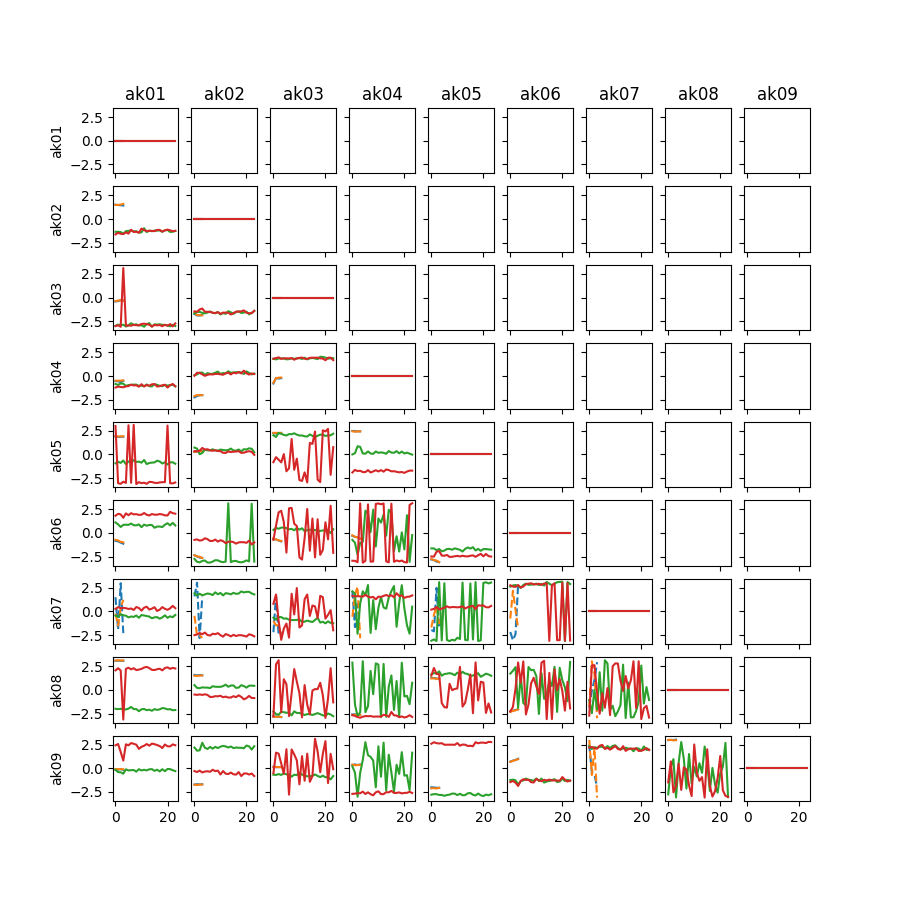

In [440]:
nant = len(ants)
fig, ax = subplots(nant, nant, sharex=True, sharey=True)
fig.set_size_inches(9,9)
for ia1 in range(nant):
    for ia2 in range(ia1, nant):
        idx = np.where((ia1+1 == d['antenna1']) & (ia2+1 == d['antenna2']))[0][0]        
        dplt = d['data'][:,:,idx]
        if np.any(d['flag'][:,:,idx]):
            ls = '--'
            #ax[ia2,ia1].text('F',0.1,0.1)
        else:
            ls = '-'
        ax[ia2,ia1].plot(np.angle(dplt.T), ls=ls)
        craco_data = dcmean[:,revproducts[(ia1+1,ia2+1)],:]
        ax[ia2,ia1].plot(np.angle(craco_data))
        
        if ia1 == 0:
            ax[ia2,0].set_ylabel(f'ak{ia2+1:02d}')
            
        if ia2 == nant - 1:
            ax[0,ia1].set_title(f'ak{ia1+1:02d}')
        
        

In [425]:
npol = 2
nant = len(ants)

cracod = np.zeros((nant,nant,npol,24), dtype=np.complex)
msd = np.zeros((nant,nant,npol,4), dtype=np.complex)
cracoda = []
msda = []

for ia1 in range(nant):
    for ia2 in range(ia1, nant):
        idx = np.where((ia1+1 == d['antenna1']) & (ia2+1 == d['antenna2']))[0][0]        
        msd[ia2,ia1,...] = d['data'][:,:,idx]
        cracod[ia2,ia1,...] = dcmean[:,revproducts[(ia1+1,ia2+1)],:].T
        
        cracoda.append(cracod[ia2,ia1,...])
        msda.append(msd[ia2,ia1,...])
        
        
msda = np.array(msda)
cracoda = np.array(cracoda)
cracoda.shape

(465, 2, 24)

<IPython.core.display.Javascript object>


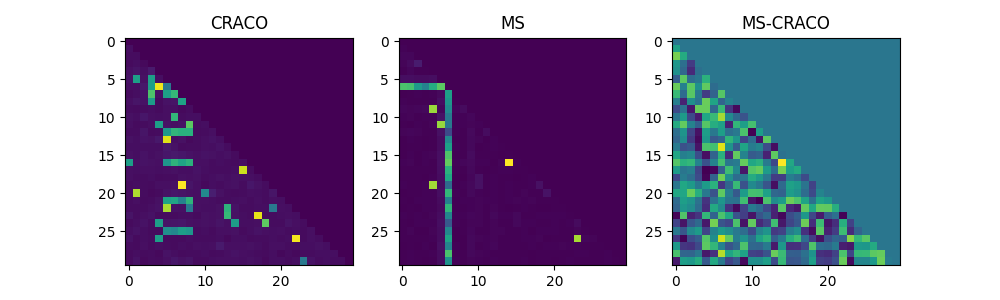

Text(0.5, 1.0, 'MS-CRACO')

In [441]:
fig, ax = subplots(1,3)
fig.set_size_inches(10,3)
ax[0].imshow(np.angle(cracod).std(axis=3)[...,0])
ax[1].imshow(np.angle(msd).std(axis=3)[...,0])
ax[2].imshow(np.angle(msd).std(axis=3)[...,0]-np.angle(cracod).mean(axis=3)[...,0])
ax[0].set_title('CRACO')
ax[1].set_title('MS')
ax[2].set_title('MS-CRACO')


<IPython.core.display.Javascript object>


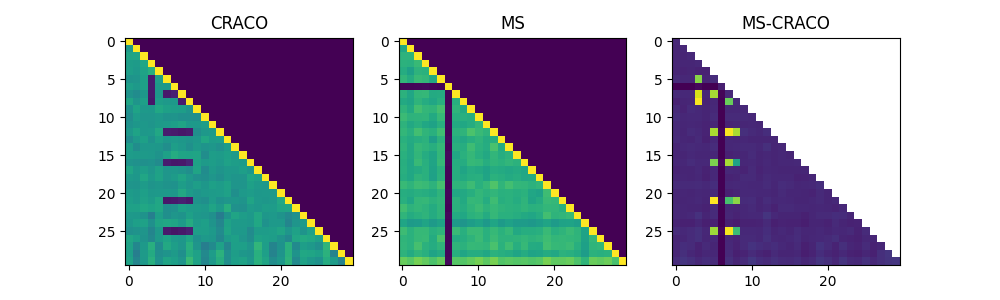

/data/craco/ban115/craco-python/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Text(0.5, 1.0, 'MS-CRACO')

In [456]:
fig, ax = subplots(1,3)
fig.set_size_inches(10,3)
ax[0].imshow(np.abs(cracod).mean(axis=3)[...,0],vmax=500/2)
ax[1].imshow(np.abs(msd).mean(axis=3)[...,0],vmax=3000/2)
ax[2].imshow(np.abs(msd).mean(axis=3)[...,0]/np.abs(cracod).mean(axis=3)[...,0])
ax[0].set_title('CRACO')
ax[1].set_title('MS')
ax[2].set_title('MS-CRACO')

In [399]:
cracoda.shape

(45, 2, 24)

In [400]:
msda.shape

(45, 2, 4)

<IPython.core.display.Javascript object>


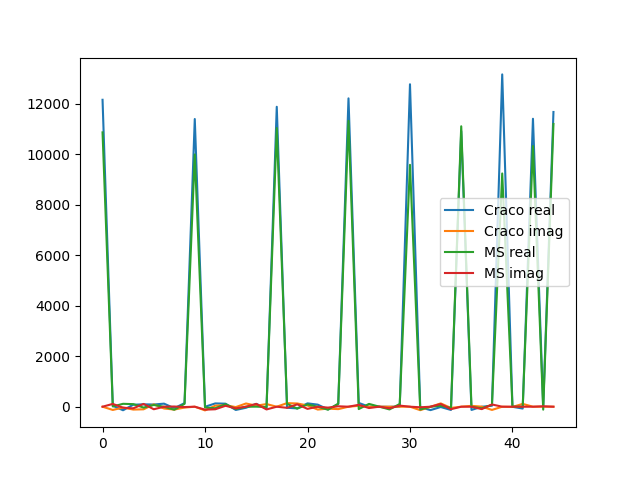

In [401]:
figure()
scale = 8
plot(cracoda[:,0,:].mean(axis=1).real, label='Craco real')
plot(cracoda[:,0,:].mean(axis=1).imag, label='Craco imag')
plot(msda[:,0,:].mean(axis=1).real/scale, label='MS real')
plot(msda[:,0,:].mean(axis=1).imag/scale, label='MS imag')
legend()

<IPython.core.display.Javascript object>


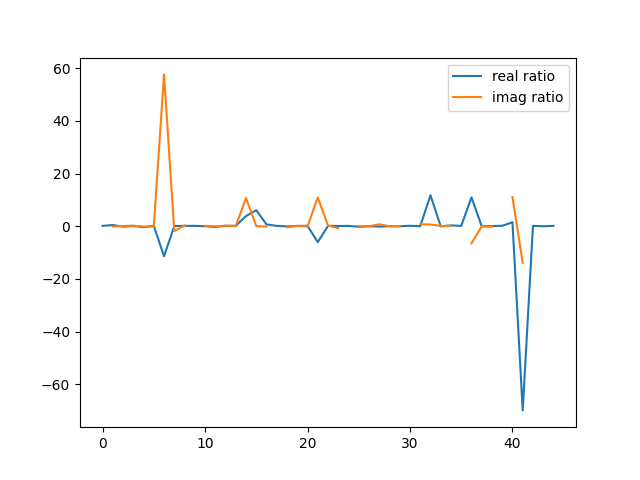

/data/craco/ban115/craco-python/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [402]:
figure()
plot(cracoda[:,0,:].mean(axis=1).real/msda[:,0,:].mean(axis=1).real, label='real ratio')
plot(cracoda[:,0,:].mean(axis=1).imag/msda[:,0,:].mean(axis=1).imag, label='imag ratio')
legend()

<IPython.core.display.Javascript object>


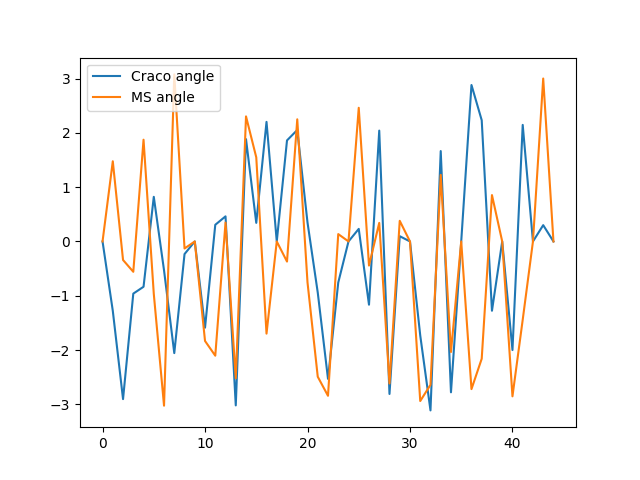

In [403]:
figure()
scale = 8
plot(np.angle(cracoda[:,0,:].mean(axis=1)), label='Craco angle')
plot(np.angle(msda[:,0,:].mean(axis=1)), label='MS angle')
legend()

In [475]:
v = np.arange(16).reshape(4,4).T
v

array([[ 0,  4,  8, 12],
       [ 1,  5,  9, 13],
       [ 2,  6, 10, 14],
       [ 3,  7, 11, 15]])

In [476]:
np.tril(v)

array([[ 0,  0,  0,  0],
       [ 1,  5,  0,  0],
       [ 2,  6, 10,  0],
       [ 3,  7, 11, 15]])

In [469]:
v.T

array([[ 0,  4,  8, 12],
       [ 1,  5,  9, 13],
       [ 2,  6, 10, 14],
       [ 3,  7, 11, 15]])

In [470]:
v.T.flatten()

array([ 0,  4,  8, 12,  1,  5,  9, 13,  2,  6, 10, 14,  3,  7, 11, 15])